In [1]:
import numpy as np
import pandas as pd

# Scikit-learn Kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2, SelectKBest

# NLTK Kütüphaneleri
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer

# SpaCy Kütüphanesi
import spacy

In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.6 MB/s eta 0:00:00


In [3]:
import os

# /kaggle/input altında hangi dosyalar var, listeleyelim
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [5]:
# Read the dataset with name "Emotion_classify_Data.csv" and store it in a variable df
columns = ['id','uygulama','duygu_durumu','metin']
df_train= pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", names=columns)
df_validation = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", names=columns)

In [6]:
df_train.head(5)

,id,uygulama,duygu_durumu,metin
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
df_validation.head(5)

,id,uygulama,duygu_durumu,metin
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            74682 non-null  int64 
 1   uygulama      74682 non-null  object
 2   duygu_durumu  74682 non-null  object
 3   metin         73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
# Check the distribution of Emotion
df_train['duygu_durumu'].value_counts()

duygu_durumu
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [10]:
#örnek gözlemler
for i in range(100):
    if i%25==0:
        print(f"{i+1}: {df_train['metin'][i]} -> {df_train['duygu_durumu'][i]}")

1: im getting on borderlands and i will murder you all , -> Positive
26: The biggest disappointment of my life came a year ago. -> Negative
51: Guilty of sobriety! A bit of a borderline. I was called to work early tomorrow, so I can't catch up. -> Neutral
76: imma probably play live borderlands tps in a bit. that'll be fun -> Positive


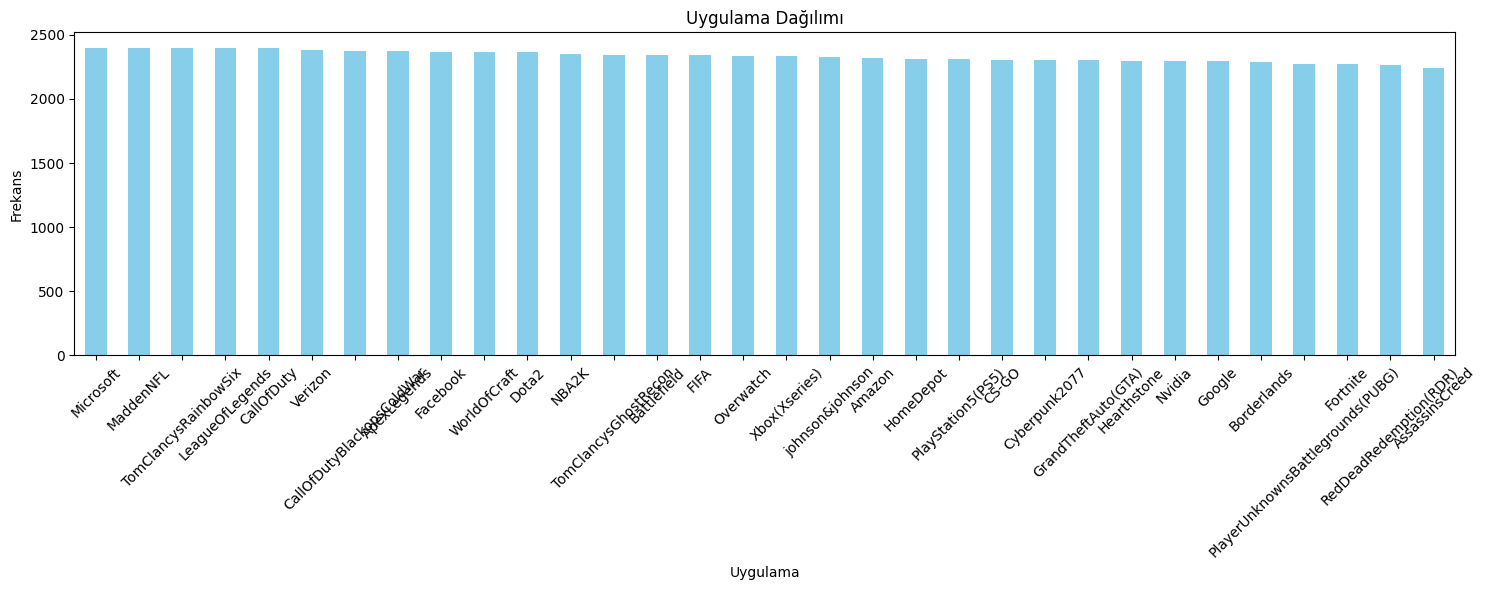

In [11]:
import matplotlib.pyplot as plt

# Uygulama sayımlarını al
uygulama_sayim = df_train['uygulama'].value_counts()

# Grafik çizimi
plt.figure(figsize=(15, 6))
uygulama_sayim.plot(kind='bar', color='skyblue')
plt.title('Uygulama Dağılımı')
plt.xlabel('Uygulama')
plt.ylabel('Frekans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
#id nasıl bir değişken diye kontrol ettiğimizde daha çok bireye veya grupa ait olduğunu gözlemledik
df_train['id'].nunique()

12447

# PREPROCESSING

In [13]:
# NLTK stopwords ve tokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
import re
import pandas as pd

def replace_urls_and_users(text):
    if isinstance(text, str): 
        text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
        text = re.sub(r'@\w+', 'AT_USER', text)
        return text
    return text 

df_train['metin'] = df_train['metin'].astype(str).apply(replace_urls_and_users)
df_validation['metin'] = df_validation['metin'].astype(str).apply(replace_urls_and_users)

print(df_train['metin'].head(3))

0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
Name: metin, dtype: object


In [15]:
import contractions

# Metindeki  kısaltmaları açan fonksiyon
def expand_with_library(text):
    return contractions.fix(text)

    
df_train['metin'] = df_train['metin'].astype(str).apply(expand_with_library)
df_validation['metin'] = df_validation['metin'].astype(str).apply(expand_with_library)

print(df_train['metin'].head(3))

0    i am getting on borderlands and i will murder ...
1    I am coming to the borders and I will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


In [16]:
# Metni küçük harfe dönüştürme işlemi
df_train['metin'] = df_train['metin'].str.lower()
df_validation['metin'] = df_validation['metin'].str.lower()


print(df_train['metin'].head(3))

0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


In [17]:
import re

# Sayıları kaldırma işlemi
df_train['metin'] = df_train['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))
df_validation['metin'] = df_validation['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))


print(df_train['metin'].head(3))

0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


In [18]:
#tekrarlanan noktalama işaretleri
df_train['metin'] = df_train['metin'].apply(lambda s: re.sub(r'([!?.,])\1+', r'\1', s))
df_validation['metin'] = df_validation['metin'].apply(lambda s: re.sub(r'([!?.,])\1+', r'\1', s))

print(df_train['metin'].head(3))

0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


In [19]:
#noktalama işaretleri
df_train['metin'] = df_train['metin'].str.replace('[^\w\s]', '')
df_validation['metin'] = df_validation['metin'].str.replace('[^\w\s]', '')

print(df_train['metin'].head(3))

0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


In [20]:
# 2. Negation kelimeleri (genişletilmiş set)
negations = {
    'not', 'no', 'never', 'none', 'cannot',
    'do not', 'does not', 'did not',
    'has not', 'have not', 'had not',
    'will not', 'would not', 'can not', 'should not',
    'might not', 'must not'
}

# 3. Stopwords listesinden negation'ları çıkar
stop_words = set(stopwords.words('english')) - negations

# 4. Metin üzerinde kelime bazlı stopword temizliği
df_train['metin'] = df_train['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)
df_validation['metin'] = df_validation['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)

In [21]:
label_mapping = {label: idx for idx, label in enumerate(df_train['duygu_durumu'].unique())}
rev_label_mapping = {idx: label for label, idx in label_mapping.items()}

print("Label mapping:")
print(label_mapping)

Label mapping:
{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}


In [22]:
# Convert labels to numerical values
y_train = df_train['duygu_durumu'].map(label_mapping)
y_val = df_validation['duygu_durumu'].map(label_mapping)

In [23]:
# Tokenize the text
max_features = 10000  # Maximum number of words to keep
maxlen = 100  # Max sequence length

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_train['metin'])

2025-05-17 10:10:31.890757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747476632.126958      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747476632.177862      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
X_train = tokenizer.texts_to_sequences(df_train['metin'])
X_val = tokenizer.texts_to_sequences(df_validation['metin'])

In [55]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X_train, 
    y_train, 
    test_size=0.1, 
    random_state=42, 
    stratify=y_train
)

# Güncellenmiş train setini kullan
X_train = X_temp
y_train = y_temp

print(f"X_train boyutu: {len(X_train)}")
print(f"X_test boyutu: {len(X_test)}")
print(f"X_val boyutu: {len(X_val)}")

X_train boyutu: 67213
X_test boyutu: 7469
X_val boyutu: 1000


In [56]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

print(f"X_train şekli: {X_train.shape}")
print(f"X_test şekli: {X_test.shape}")
print(f"X_val şekli: {X_val.shape}")

X_train şekli: (67213, 100)
X_test şekli: (7469, 100)
X_val şekli: (1000, 100)


In [28]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (74682, 100)
X_val shape: (1000, 100)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
#RNN model
def build_rnn_model(embedding_dim=100, rnn_units=128, dense_units=64):
    model = Sequential()
    
    model.add(Embedding(input_dim=max_features, 
                        output_dim=embedding_dim, 
                        input_length=maxlen))
    
    model.add(SpatialDropout1D(0.2))
    model.add(SimpleRNN(rnn_units, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(label_mapping), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [59]:
# Create model
model = build_rnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [61]:
model_checkpoint = ModelCheckpoint(
    'best_simple_rnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [62]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1050/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2972 - loss: 1.3842
Epoch 1: val_accuracy improved from -inf to 0.41500, saving model to best_simple_rnn_model.h5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.2973 - loss: 1.3841 - val_accuracy: 0.4150 - val_loss: 1.2619
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4985 - loss: 1.1592
Epoch 2: val_accuracy improved from 0.41500 to 0.65200, saving model to best_simple_rnn_model.h5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.4985 - loss: 1.1592 - val_accuracy: 0.6520 - val_loss: 0.8898
Epoch 3/50
1050/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6409 - loss: 0.9122
Epoch 3: val_accuracy improved from 0.65200 to 0.73500, saving model to best_simple_rnn_model.h5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.6409 - loss: 0.9122 - val_accuracy: 0.7350 - val_loss: 0.6807
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6954 - loss: 

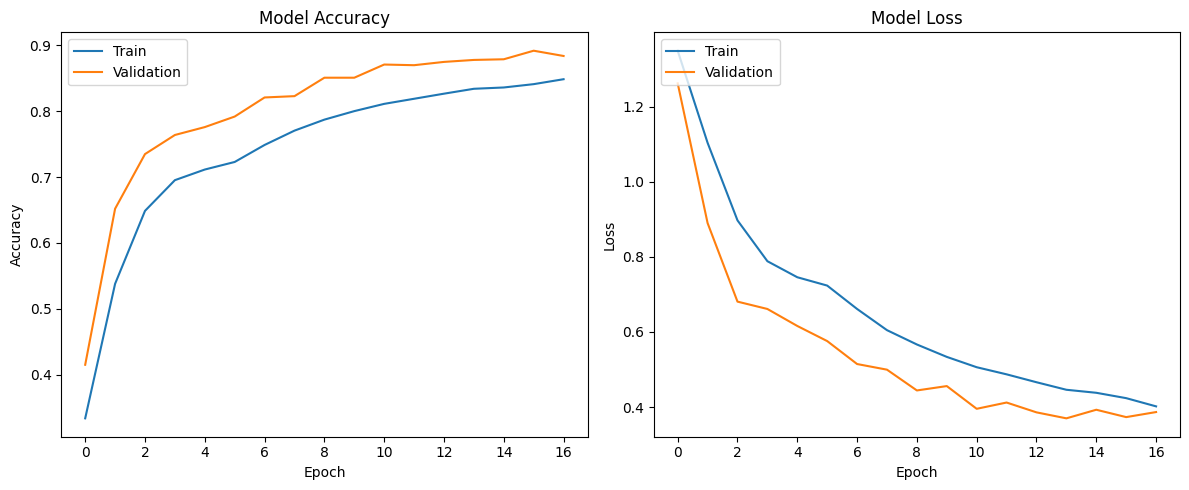

In [63]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [64]:
# Test verisi üzerinde değerlendirme
print("\n--- Test Seti Değerlendirmesi ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test setinde tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


--- Test Seti Değerlendirmesi ---
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7951 - loss: 0.5898
Test Loss: 0.5792
Test Accuracy: 0.7997
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step



--- Confusion Matrix ---


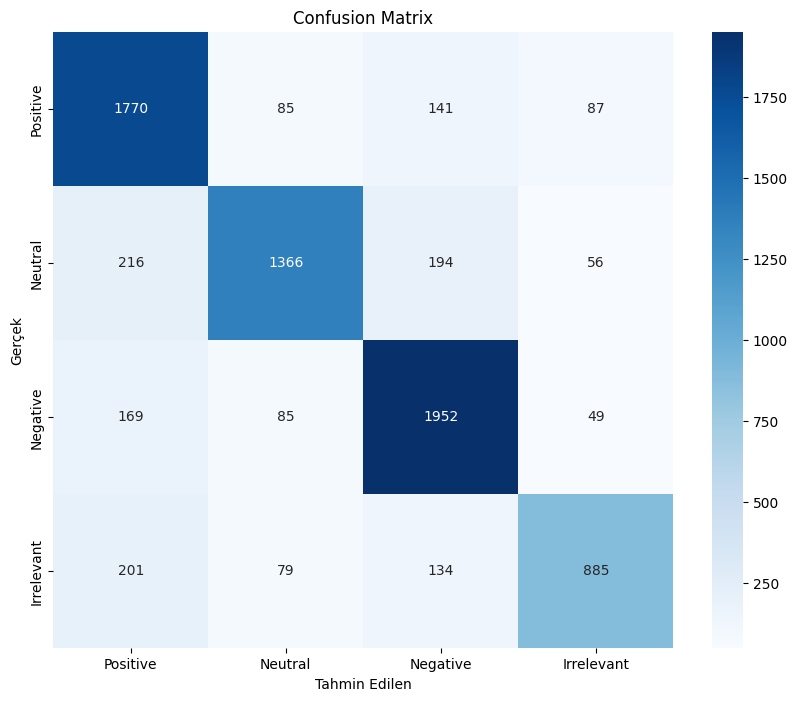

In [65]:
# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))],
            yticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [66]:
# Sınıflandırma raporu
print("\n--- Classification Report ---")
report = classification_report(
    y_test, 
    y_pred_classes, 
    target_names=[rev_label_mapping[i] for i in range(len(label_mapping))],
    digits=3
)
print(report)


--- Classification Report ---
              precision    recall  f1-score   support

    Positive      0.751     0.850     0.797      2083
     Neutral      0.846     0.746     0.793      1832
    Negative      0.806     0.866     0.835      2255
  Irrelevant      0.822     0.681     0.745      1299

    accuracy                          0.800      7469
   macro avg      0.806     0.786     0.792      7469
weighted avg      0.803     0.800     0.798      7469



# WORD2VEC

In [270]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [271]:
sentences = df_train_full["metin"].apply(word_tokenize).tolist()

In [272]:
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


In [273]:
import numpy as np

def vectorize_sentences(sentences, w2v_model, max_len=50):
    vector_size = w2v_model.vector_size
    vectorized = []

    for sentence in sentences:
        sentence_vecs = []
        for word in sentence[:max_len]:
            if word in w2v_model.wv:
                sentence_vecs.append(w2v_model.wv[word])
            else:
                sentence_vecs.append(np.zeros(vector_size))
        # Pad if sentence is shorter
        while len(sentence_vecs) < max_len:
            sentence_vecs.append(np.zeros(vector_size))
        vectorized.append(sentence_vecs)

    return np.array(vectorized)


In [274]:
X_train = vectorize_sentences(df_train_full["metin"].apply(word_tokenize), w2v_model)
X_val = vectorize_sentences(df_validation["metin"].apply(word_tokenize), w2v_model)
X_test = vectorize_sentences(df_test["metin"].apply(word_tokenize), w2v_model)

In [275]:
label_mapping = {'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}
y_train = df_train_full["duygu_durumu"].map(label_mapping).astype(np.int32).values
y_val = df_validation["duygu_durumu"].map(label_mapping).astype(np.int32).values
y_test = df_test["duygu_durumu"].map(label_mapping).astype(np.int32).values

In [276]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def build_rnn_w2v_model(input_shape, output_dim, rnn_units=128, dense_units=64):
    model = Sequential()
    model.add(Bidirectional(LSTM(rnn_units, dropout=0.2, recurrent_dropout=0.2), input_shape=input_shape))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [277]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (max_len, vector_size)
model = build_rnn_w2v_model(input_shape, output_dim=len(label_mapping))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_word2vec_rnn.h5", monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 105s 105ms/step - accuracy: 0.4832 - loss: 1.1858 - val_accuracy: 0.5520 - val_loss: 1.0519
Epoch 2/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 98s 105ms/step - accuracy: 0.5438 - loss: 1.0651 - val_accuracy: 0.5810 - val_loss: 0.9736
Epoch 3/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 99s 106ms/step - accuracy: 0.5640 - loss: 1.0181 - val_accuracy: 0.6390 - val_loss: 0.9014
Epoch 4/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 99s 105ms/step - accuracy: 0.5812 - loss: 0.9838 - val_accuracy: 0.6410 - val_loss: 0.8560
Epoch 5/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.5982 - loss: 0.9438 - val_accuracy: 0.6660 - val_loss: 0.8068
Epoch 6/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - accuracy: 0.6183 - loss: 0.9076 - val_accuracy: 0.7050 - val_loss: 0.7517
Epoch 7/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - accuracy: 0.6366 - loss: 0.8660 - val_accuracy: 0.6950 - val_loss: 0.7142
Epoch 8/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - accuracy: 0.6528 - loss: 

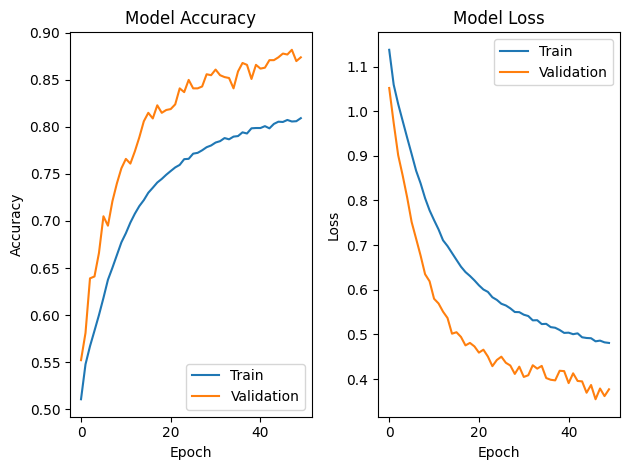

In [278]:
# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [279]:
# Test verisi üzerinde değerlendirme
print("\n--- Test Seti Değerlendirmesi ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test setinde tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


--- Test Seti Değerlendirmesi ---
467/467 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7915 - loss: 0.5638
Test Loss: 0.5543
Test Accuracy: 0.7934
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step



--- Confusion Matrix ---


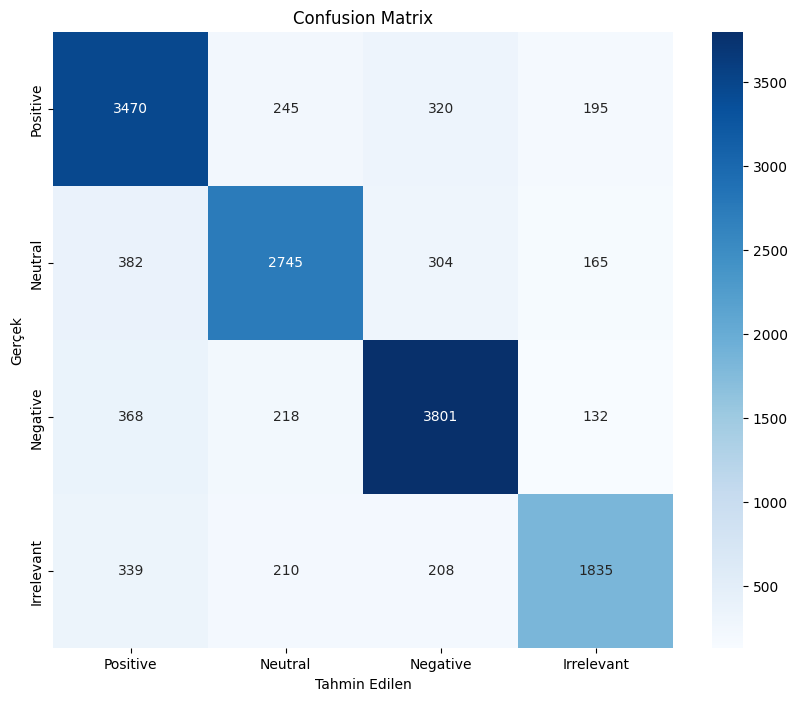

In [280]:
# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))],
            yticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [281]:
print("\n--- Classification Report ---")
report = classification_report(
    y_test, 
    y_pred_classes, 
    target_names=[rev_label_mapping[i] for i in range(len(label_mapping))],
    digits=3
)
print(report)


--- Classification Report ---
              precision    recall  f1-score   support

    Positive      0.761     0.820     0.790      4230
     Neutral      0.803     0.763     0.783      3596
    Negative      0.820     0.841     0.831      4519
  Irrelevant      0.789     0.708     0.746      2592

    accuracy                          0.793     14937
   macro avg      0.793     0.783     0.787     14937
weighted avg      0.794     0.793     0.793     14937



# GloVe

In [208]:
import gensim.downloader as api

# 1. Load pre-trained GloVe model
glove_model = api.load("glove-wiki-gigaword-100") 

In [256]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenize edilmiş metin listeleri
train_tokens = df_train_full["metin"].apply(word_tokenize)
val_tokens = df_validation["metin"].apply(word_tokenize)
test_tokens = df_test["metin"].apply(word_tokenize)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [257]:
# Eğitim, doğrulama ve test setlerini kaydet
df_train_full.to_csv("df_train_full.csv", index=False)
df_validation.to_csv("df_validation.csv", index=False)
df_test.to_csv("df_test.csv", index=False)


In [258]:
import numpy as np

def vectorize_sentences(tokens_list, glove_model, max_len=50):
    embedding_dim = glove_model.vector_size
    all_vecs = []

    for tokens in tokens_list:
        sentence_vecs = []
        for word in tokens[:max_len]:
            if word in glove_model:
                sentence_vecs.append(glove_model[word])
            else:
                sentence_vecs.append(np.zeros(embedding_dim))
        # Pad with zeros if too short
        while len(sentence_vecs) < max_len:
            sentence_vecs.append(np.zeros(embedding_dim))
        all_vecs.append(sentence_vecs)

    return np.array(all_vecs)


In [259]:
X_train = vectorize_sentences(train_tokens, glove_model)
X_val = vectorize_sentences(val_tokens, glove_model)
X_test = vectorize_sentences(test_tokens, glove_model)


In [260]:
label_mapping = {'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}
y_train = df_train_full["duygu_durumu"].map(label_mapping).astype(np.int32).values
y_val = df_validation["duygu_durumu"].map(label_mapping).astype(np.int32).values
y_test = df_test["duygu_durumu"].map(label_mapping).astype(np.int32).values


In [261]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def build_glove_rnn_model(input_shape, output_dim, rnn_units=128, dense_units=64):
    model = Sequential()
    model.add(Bidirectional(LSTM(rnn_units, dropout=0.2, recurrent_dropout=0.2), input_shape=input_shape))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


input_shape = (X_train.shape[1], X_train.shape[2])  # (max_len, embedding_dim)
model = build_glove_rnn_model(input_shape, output_dim=len(label_mapping))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [265]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_glove_gensim_rnn_model.h5", monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.6427 - loss: 0.8705 - val_accuracy: 0.7290 - val_loss: 0.6992
Epoch 2/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.6695 - loss: 0.8138 - val_accuracy: 0.7610 - val_loss: 0.6299
Epoch 3/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.6946 - loss: 0.7621 - val_accuracy: 0.7910 - val_loss: 0.5721
Epoch 4/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 100s 107ms/step - accuracy: 0.7084 - loss: 0.7217 - val_accuracy: 0.8040 - val_loss: 0.5386
Epoch 5/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.7294 - loss: 0.6747 - val_accuracy: 0.8310 - val_loss: 0.4678
Epoch 6/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - accuracy: 0.7394 - loss: 0.6533 - val_accuracy: 0.8550 - val_loss: 0.4451
Epoch 7/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 100s 107ms/step - accuracy: 0.7534 - loss: 0.6185 - val_accuracy: 0.8640 - val_loss: 0.4180
Epoch 8/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 100s 107ms/step - accuracy: 0.7640 -

In [266]:
# Test verisi üzerinde değerlendirme
print("\n--- Test Seti Değerlendirmesi ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test setinde tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


--- Test Seti Değerlendirmesi ---
467/467 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7996 - loss: 0.5395
Test Loss: 0.5329
Test Accuracy: 0.7981
467/467 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step



--- Confusion Matrix ---


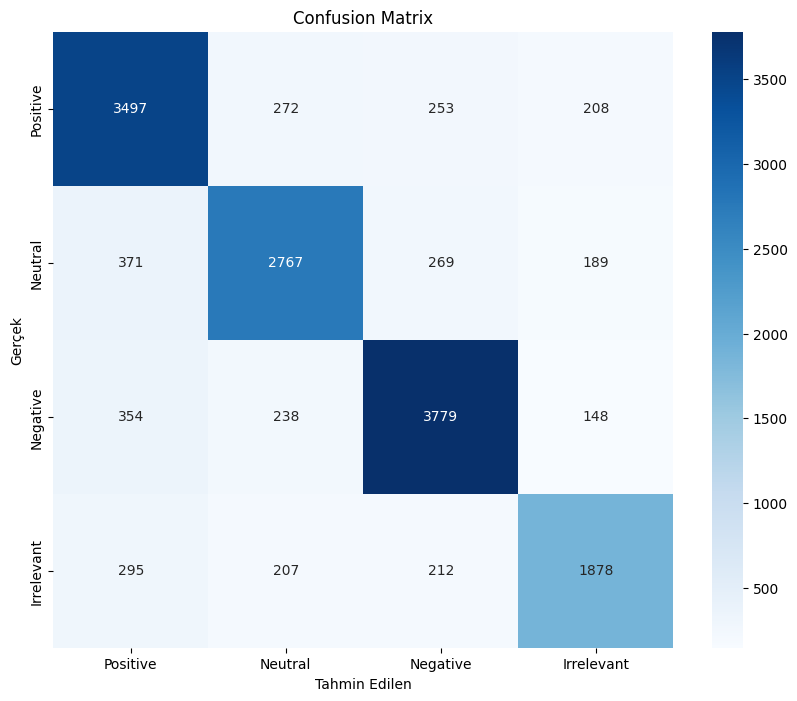

In [267]:
# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))],
            yticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [269]:
print("\n--- Classification Report ---")
report = classification_report(
    y_test, 
    y_pred_classes, 
    target_names=[rev_label_mapping[i] for i in range(len(label_mapping))],
    digits=3
)
print(report)


--- Classification Report ---
              precision    recall  f1-score   support

    Positive      0.774     0.827     0.800      4230
     Neutral      0.794     0.769     0.782      3596
    Negative      0.837     0.836     0.837      4519
  Irrelevant      0.775     0.725     0.749      2592

    accuracy                          0.798     14937
   macro avg      0.795     0.789     0.792     14937
weighted avg      0.798     0.798     0.798     14937



# FASTTEXT

In [239]:
from gensim.models import FastText
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenize
train_tokens = df_train_full["metin"].apply(word_tokenize)
val_tokens = df_validation["metin"].apply(word_tokenize)
test_tokens = df_test["metin"].apply(word_tokenize)

# FastText modelini eğit
fasttext_model = FastText(sentences=train_tokens, vector_size=100, window=5, min_count=1, epochs=10)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [240]:
import numpy as np

def vectorize_sentences(tokens_list, model, max_len=50):
    embedding_dim = model.vector_size
    all_vecs = []

    for tokens in tokens_list:
        sentence_vecs = []
        for word in tokens[:max_len]:
            sentence_vecs.append(model.wv[word] if word in model.wv else np.zeros(embedding_dim))
        while len(sentence_vecs) < max_len:
            sentence_vecs.append(np.zeros(embedding_dim))
        all_vecs.append(sentence_vecs)

    return np.array(all_vecs)

# Vektörleştir
X_train = vectorize_sentences(train_tokens, fasttext_model)
X_val = vectorize_sentences(val_tokens, fasttext_model)
X_test = vectorize_sentences(test_tokens, fasttext_model)


In [241]:
label_mapping = {'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}
y_train = df_train_full["duygu_durumu"].map(label_mapping).astype(np.int32).values
y_val = df_validation["duygu_durumu"].map(label_mapping).astype(np.int32).values
y_test = df_test["duygu_durumu"].map(label_mapping).astype(np.int32).values


In [242]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def build_fasttext_rnn_model(input_shape, output_dim, rnn_units=128, dense_units=64):
    model = Sequential()
    model.add(Bidirectional(LSTM(rnn_units, dropout=0.2, recurrent_dropout=0.2), input_shape=input_shape))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (max_len, vector_size)
model = build_fasttext_rnn_model(input_shape, output_dim=len(label_mapping))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,204 (981.27 KB)

 Trainable params: 251,204 (981.27 KB)

 Non-trainable params: 0 (0.00 B)

In [243]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_fasttext_custom_rnn_model.h5", monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 109s 107ms/step - accuracy: 0.4927 - loss: 1.1726 - val_accuracy: 0.6090 - val_loss: 0.9670
Epoch 2/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 98s 105ms/step - accuracy: 0.5635 - loss: 1.0346 - val_accuracy: 0.6370 - val_loss: 0.8839
Epoch 3/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.6024 - loss: 0.9607 - val_accuracy: 0.6780 - val_loss: 0.8101
Epoch 4/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 95s 102ms/step - accuracy: 0.6305 - loss: 0.9011 - val_accuracy: 0.7020 - val_loss: 0.7541
Epoch 5/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.6542 - loss: 0.8463 - val_accuracy: 0.7300 - val_loss: 0.6907
Epoch 6/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - accuracy: 0.6722 - loss: 0.8103 - val_accuracy: 0.7490 - val_loss: 0.6383
Epoch 7/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 98s 105ms/step - accuracy: 0.6953 - loss: 0.7619 - val_accuracy: 0.7850 - val_loss: 0.5693
Epoch 8/50
934/934 ━━━━━━━━━━━━━━━━━━━━ 98s 105ms/step - accuracy: 0.7090 - loss: 

In [244]:
# Test verisi üzerinde değerlendirme
print("\n--- Test Seti Değerlendirmesi ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test setinde tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


--- Test Seti Değerlendirmesi ---
467/467 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8003 - loss: 0.5330
Test Loss: 0.5374
Test Accuracy: 0.7989
467/467 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step



--- Confusion Matrix ---


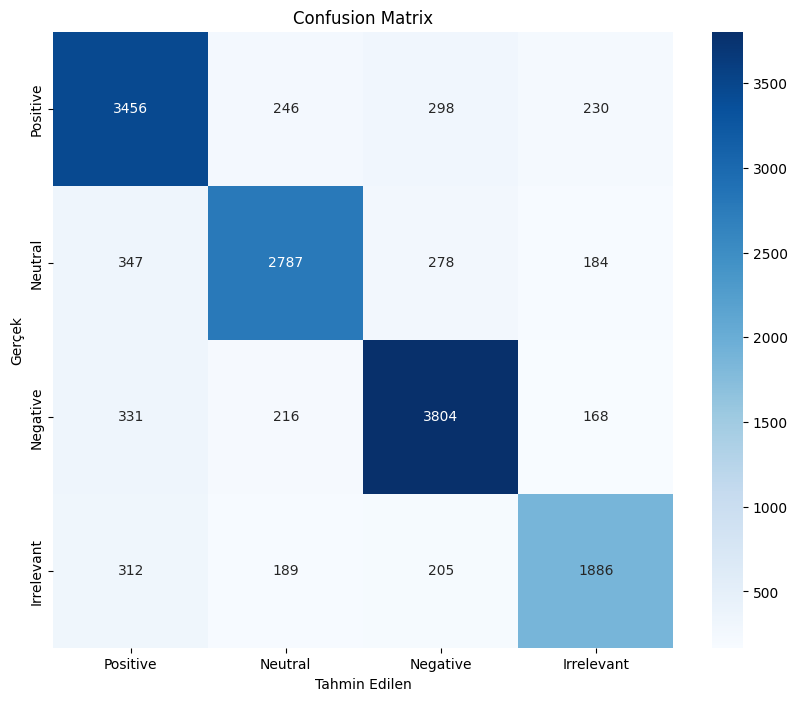

In [245]:
# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))],
            yticklabels=[rev_label_mapping[i] for i in range(len(label_mapping))])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()